# Classification
stralcio + domanda -> repertorio

In [68]:
import pandas as pd
import neptune.new as neptune
import random
import os

In [69]:
#Neptune initialization
run = neptune.init(
    project="mibo8/Rep",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmZmRkYThiZi1mZGNlLTRlMTktODQwNS1hNWFlMWQ2Mjc4N2IifQ==",
)  # your credentials

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [70]:
#Deterministic mode

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#seed_everything()



# Dataset loading and preprocessing

In [71]:
def fill_null_features(df):
    for c in ['Domanda','Testo']:
        for i in range(0,len(df.index)):  
            if not df[c][i]:
                j=i
                while j>0: 
                    j-=1
                    if df[c][j]:
                        df[c][i] = df[c][j]
                        break
    return df

In [72]:
#Hyperion dataset
df = pd.read_csv('../data/Original_csv/Hyperion.csv', na_filter=False)
df = fill_null_features(df)

print('Numero stralci: ' + str(len(df.index)))
filter = df["Repertorio"] != ""
df = df[filter]
print('Numero stralci dopo eliminazione: ' + str(len(df.index)))

# lower entire dataset
df = df.applymap(str.lower)

Numero stralci: 35474
Numero stralci dopo eliminazione: 35148


In [73]:
#Lables uniformation uncased

df['Repertorio'].replace('implicazioni','implicazione', inplace=True)
df['Repertorio'].replace('previsioni','previsione', inplace=True)

In [74]:
# split
test_set_perc = 0.2
val_set_perc = 0.1

gb = df.groupby('Repertorio')
train_list = []
test_list = []
val_list = []

for x in gb.groups:
    class_df = gb.get_group(x)

    # Test set creation
    test = class_df.sample(frac=test_set_perc, random_state=1464)
    train = pd.concat([class_df,test]).drop_duplicates(keep=False)

    # Validation set creation
    val = train.sample(frac=val_set_perc)
    train = pd.concat([train,val]).drop_duplicates(keep=False)

    train_list.append(train)
    test_list.append(test)
    val_list.append(val)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)
val_df = pd.concat(val_list)

dataset_info = {
    'training_set_size' : 1 - test_set_perc,
    'validation_set_size' : val_set_perc,
    'test_set_size' : test_set_perc
}
run['dataset'] = dataset_info

In [75]:
import torch

class HyperionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

## X = Domanda + stralcio

In [76]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")

model = AutoModelForSequenceClassification.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0", num_labels=23)

Some weights of the model checkpoint at m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

In [77]:
run['model'] = "bert-base-multilingual-uncased"

In [78]:
from sklearn import preprocessing

training_encodings = tokenizer(
            train_df['Stralcio'][:100].tolist(),
            max_length=512,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            truncation=True
        )
test_encodings = tokenizer(
            test_df['Stralcio'][:100].tolist(),
            max_length=512,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            truncation=True
)
val_encodings = tokenizer(
            val_df['Stralcio'][:100].tolist(),
            max_length=512,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            truncation=True
)


labels = [
    'anticipazione',
    'causa',
    'commento',
    'conferma',
    'considerazione',
    'contrapposizione',
    'deresponsabilizzazione',
    'descrizione',
    'dichiarazione di intenti',
    'generalizzazione',
    'giudizio',
    'giustificazione',
    'implicazione',
    'non risposta',
    'opinione',
    'possibilità',
    'prescrizione',
    'previsione',
    'proposta',
    'ridimensionamento',
    'sancire',
    'specificazione',
    'valutazione']

le = preprocessing.LabelEncoder()
le.fit(labels)

train_dataset = HyperionDataset(training_encodings,le.transform(train_df['Repertorio'][:100]))
test_dataset = HyperionDataset(test_encodings,le.transform(test_df['Repertorio'][:100]))
val_dataset = HyperionDataset(val_encodings,le.transform(val_df['Repertorio'][:100]))


In [79]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [80]:
import  torchmetrics

# Metrics initialization
metric_collection = torchmetrics.MetricCollection({

    'accuracy_micro' : torchmetrics.Accuracy(num_classes=23, multiclass=True, average='micro'),
    'accuracy_macro' : torchmetrics.Accuracy(num_classes=23, multiclass=True, average='macro'),
    'accuracy_weighted' : torchmetrics.Accuracy(num_classes=23, multiclass=True, average='weighted'),
    'accuracy_none' : torchmetrics.Accuracy(num_classes=23, multiclass=True, average='none'),

    'f1_micro' : torchmetrics.F1(num_classes=23, multiclass=True, average='micro'),
    'f1_macro' : torchmetrics.F1(num_classes=23, multiclass=True, average='macro'),
    'f1_weighted' : torchmetrics.F1(num_classes=23, multiclass=True, average='weighted'),
    'f1_none' : torchmetrics.F1(num_classes=23, multiclass=True, average='none'),

    'precision_micro' : torchmetrics.Precision(num_classes=23, multiclass=True, average='micro'),
    'precision_macro' : torchmetrics.Precision(num_classes=23, multiclass=True, average='macro'),
    'precision_weighted' : torchmetrics.Precision(num_classes=23, multiclass=True, average='weighted'),
    'precision_none' : torchmetrics.Precision(num_classes=23, multiclass=True, average='none'),

    'recall_micro' : torchmetrics.Recall(num_classes=23, multiclass=True, average='micro'),
    'recall_macro' : torchmetrics.Recall(num_classes=23, multiclass=True, average='macro'),
    'recall_weighted' : torchmetrics.Recall(num_classes=23, multiclass=True, average='weighted'),
    'recall_none' : torchmetrics.Recall(num_classes=23, multiclass=True, average='none')
})


In [81]:
# Hyperparameters
learning_rate = 1e-5
batch_size = 4
n_epochs = 1

params_info = {
    'learning_rate' : learning_rate,
    'batch_size' : batch_size,
    'n_epochs' : n_epochs
}
run['params'] = params_info

In [82]:
train_df.groupby('Repertorio')['Repertorio'].count()

Repertorio
anticipazione                 38
causa                        340
commento                    3153
conferma                     460
considerazione               225
contrapposizione            1015
deresponsabilizzazione       455
descrizione                 3502
dichiarazione di intenti     463
generalizzazione             768
giudizio                    1986
giustificazione              316
implicazione                 509
non risposta                 835
opinione                     965
possibilità                  444
prescrizione                1381
previsione                   840
proposta                     185
ridimensionamento            792
sancire                     4045
specificazione              1004
valutazione                 1528
Name: Repertorio, dtype: int64

In [83]:
from torch.utils.data import DataLoader
from transformers import  AdamW

import numpy as np


# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = n_epochs

# Creation of Pytorch DataLoaders with shuffle=True for the traing phase
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#Adam algorithm optimized for tranfor architectures
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Setup for training with gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode: Dropout layers are active
    model.train()
    
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 10 == 0 and not step == 0:
            # Compute time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from the dataloader. 
        #
        #  copy each tensor to the GPU using the 'to()' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # clear any previously calculated gradients before performing a
        # backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        outputs = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_train_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu()
        label_ids = b_labels.to('cpu')

        batch_metric = metric_collection.update(logits.softmax(dim=1), label_ids)
        #print(batch_metric)

        # Perform a backward pass to compute the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This helps and prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()


    # Compute the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    final_metrics = metric_collection.compute()
    print(final_metrics)
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure performance on
    # the validation set.

    print("")
    print("Running Validation...")

    metric_collection.reset()
    t0 = time.time()

    # Put the model in evaluation mode: the dropout layers behave differently
    model.eval()

    total_val_loss = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # copy each tensor to the GPU using the 'to()' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for training.
        with torch.no_grad():        

            # Forward pass, calculate logits
            # argmax(logits) = argmax(Softmax(logits))
            outputs = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        # Accumulate the validation loss.
        total_val_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu()
        label_ids = b_labels.to('cpu')

        # metric on current batch
        batch_metric = metric_collection.update(logits.softmax(dim=1), label_ids)

    # Report the final metrics for this validation phase.
    # metric on all batches using custom accumulation from torchmetrics library

    final_metrics = metric_collection.compute()
    print('VALIDATION: ')
    print(final_metrics)
    # Compute the average loss over all of the batches.
    avg_val_loss = total_val_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...
  Batch    10  of     25.    Elapsed: 0:00:32.
  Batch    20  of     25.    Elapsed: 0:01:04.


{'accuracy_macro': tensor(0.1399), 'accuracy_micro': tensor(0.4700), 'accuracy_none': tensor([0.2105, 0.6290,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
        0.0000,    nan, 0.0000,    nan,    nan,    nan, 0.0000,    nan, 0.0000,
           nan,    nan,    nan,    nan,    nan]), 'accuracy_weighted': tensor(0.4700), 'f1_macro': tensor(0.1544), 'f1_micro': tensor(0.4700), 'f1_none': tensor([0.2712, 0.6555,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
        0.0000,    nan, 0.0000,    nan,    nan,    nan, 0.0000,    nan, 0.0000,
           nan,    nan,    nan,    nan,    nan]), 'f1_weighted': tensor(0.5094), 'precision_macro': tensor(0.1775), 'precision_micro': tensor(0.4700), 'precision_none': tensor([0.3810, 0.6842,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
        0.0000,    nan, 0.0000,    nan,    nan,    nan, 0.0000,    nan, 0.0000,
           nan,    nan,    nan,    nan,    nan]), 'precision_weighted': tensor(0.5690), 'recall_macro': tensor(

In [84]:
# ========================================
#               Test
# ========================================
# Measure performance on
# the validation set.

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("")
print("Running Test...")

metric_collection.reset()
t0 = time.time()

# Save prediction for confusion matrix
pred = []

# Put the model in evaluation mode: the dropout layers behave differently
model.eval()

total_test_loss = 0

# Evaluate data for one epoch
for batch in test_dataloader:
    
    # Unpack this training batch from our dataloader. 
    #
    # copy each tensor to the GPU using the 'to()' method
    #
    # 'batch' contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
    b_labels = batch['labels'].to(device)
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for training.
    with torch.no_grad():        

        # Forward pass, calculate logits
        # argmax(logits) = argmax(Softmax(logits))
        outputs = model(b_input_ids, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        
    # Accumulate the validation loss.
    total_test_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu()
    label_ids = b_labels.to('cpu')

    batch_pred = logits.softmax(dim=1)
    pred += batch_pred.argmax(dim=1)

    # metric on current batch

    batch_metric = metric_collection.update(batch_pred, label_ids)

# Report the final metrics for this validation phase.
# metric on all batches using custom accumulation from torchmetrics library

test_metrics = metric_collection.compute()
print(' Test metrics: ')
print(final_metrics)

run['metrics'] = final_metrics
# Compute the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

run['test/loss'] = avg_test_loss

# Measure how long the validation run took.
test_time = format_time(time.time() - t0)

print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))

#torch.save(model.state_dict(), "./")



Running Test...
 Test metrics: 
{'accuracy_macro': tensor(0.4167), 'accuracy_micro': tensor(0.3900), 'accuracy_none': tensor([0.2500, 1.0000, 0.0000,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan]), 'accuracy_weighted': tensor(0.3900), 'f1_macro': tensor(0.2974), 'f1_micro': tensor(0.3900), 'f1_none': tensor([0.3333, 0.5588, 0.0000,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan]), 'f1_weighted': tensor(0.2257), 'precision_macro': tensor(0.2959), 'precision_micro': tensor(0.3900), 'precision_none': tensor([0.5000, 0.3878, 0.0000,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan]), 'precision_weighted': tensor

/home/michele/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


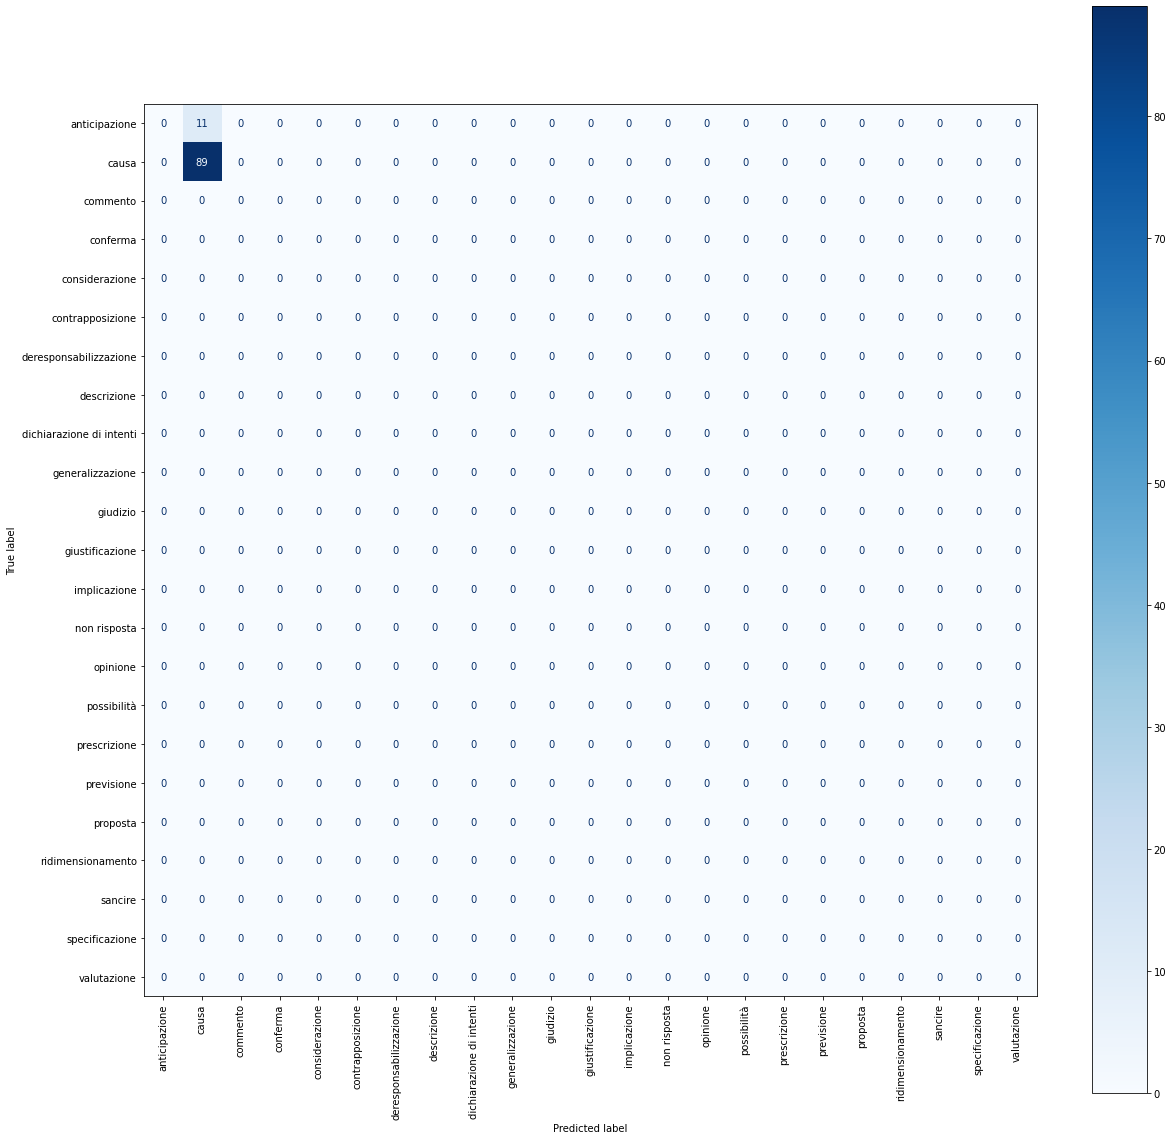

In [89]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

encoded_labels = le.transform(labels)
y_true = test_dataset[:]['labels']
fig, ax = plt.subplots(figsize=(20, 20))
cm = confusion_matrix(y_true, pred, encoded_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap="Blues", values_format='',xticks_rotation='vertical' ,ax = ax)

run["confusion_matrix"].upload(neptune.types.File.as_image(disp.figure_))



In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!
